### **Bibliotecas**

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### **Import Data**

In [2]:
dataset_name = 'diabetes_prediction_dataset.csv'
dataset = pd.read_csv(dataset_name)

dataset.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
print(f">> Dataset shape: {dataset.shape}")

>> Dataset shape: (100000, 9)


In [4]:
print(f">> Proporção das classes: \n{dataset['diabetes'].value_counts()}" )

>> Proporção das classes: 
diabetes
0    91500
1     8500
Name: count, dtype: int64


#### **Gerar novos datasets**

In [5]:
diabetes_dataset = pd.read_csv('diabetes_prediction_dataset.csv')

train_dataset, test_dataset = train_test_split(diabetes_dataset, test_size=0.3, random_state=42)

# Gerar e salvar novo dataset contendo dados negativos
diabetes_negative = train_dataset.loc[diabetes_dataset['diabetes'] == 0]

### **Normalizar e Encode**

In [6]:
def set(diabetes_negative, test_dataset):
    X_train = diabetes_negative.drop(columns=['diabetes'])
    X_test = test_dataset.drop(columns=['diabetes'])
    y_test = test_dataset['diabetes']

    # Codifica as colunas 'gender', 'smoking_history'
    columns_to_encode = ['gender', 'smoking_history']
    X_train_encoded = pd.get_dummies(X_train, columns=columns_to_encode)
    X_test_encoded = pd.get_dummies(X_test, columns=columns_to_encode)

    scaler = StandardScaler(with_mean=False)
    scaler.fit(X_train_encoded)

    X_train_scaled = scaler.transform(X_train_encoded)
    X_test_scaled = scaler.transform(X_test_encoded)

    return X_train_scaled, X_test_scaled, y_test

In [7]:
X_train_scaled, X_test_scaled, y_test = set(diabetes_negative, test_dataset)

In [8]:
print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (64047, 15)
X_test shape: (30000, 15)
y_test shape: (30000,)


### **NF**

In [9]:
!pip install normflows

In [10]:
# Import required packages
import torch
import torchvision as tv
import numpy as np
import normflows as nf
import torch.optim as optim
from sklearn.metrics import roc_curve, auc

from matplotlib import pyplot as plt
from tqdm import tqdm

In [11]:
torch.manual_seed(42)
np.random.seed(42)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

In [12]:
# Define 64-dimensional Gaussian base distribution (adjust as needed)
base = nf.distributions.base.DiagGaussian(15)

# Define list of flows
num_layers = 16
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([8, 64, 64, 64, 128, 64, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))

In [13]:
# Define Normalizing Flow model
model = nf.NormalizingFlow(base, flows)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# If the target density is not given
model = nf.NormalizingFlow(base, flows)

In [15]:
# Train the Normalizing Flow model
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward KL divergence (no target distribution given)
    loss = model.forward_kld(X_train_tensor)

    # Optimization step
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

Epoch 0/500, Loss: 56.73697280883789
Epoch 100/500, Loss: 15.582576751708984
Epoch 200/500, Loss: 14.239214897155762
Epoch 300/500, Loss: 13.244946479797363
Epoch 400/500, Loss: 10.690258979797363


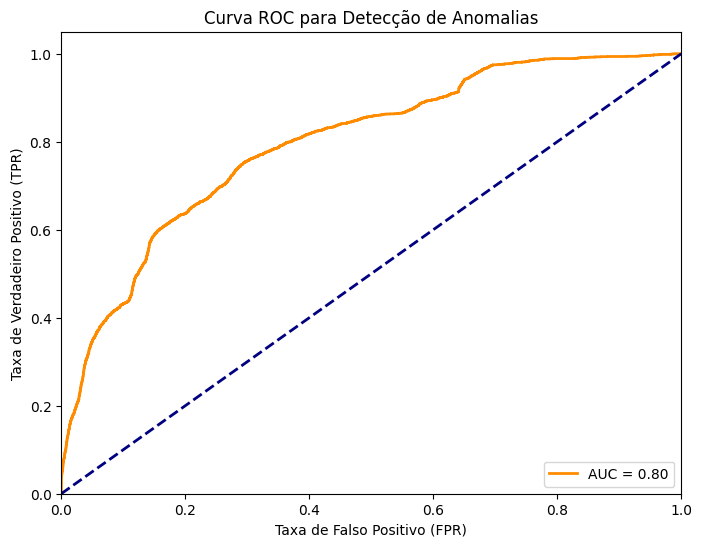

In [16]:
# Calculate anomaly scores for each sample in the test set
with torch.no_grad():
    anomaly_scores = -model.log_prob(X_test_tensor)

# print(anomaly_scores[5])
# # Define um limiar para detecção de anomalia
threshold = np.percentile(anomaly_scores.numpy(), 95)

# # Identifica instâncias com pontuações de anomalia acima do limiar
predicted_labels = (anomaly_scores > torch.tensor(threshold)).numpy()

# Calcula a curva ROC
fpr, tpr, _ = roc_curve(y_test, anomaly_scores.numpy())
roc_auc = auc(fpr, tpr)

# Plota a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC para Detecção de Anomalias')
plt.legend(loc="lower right")
plt.show()